In [1]:
import numpy as np
from scipy import ndimage as nd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import cv2

In [2]:
# Gradient in x-direction
def Sobelx(image):
    sobelx = np.array([[1,0,-1],
                    [2,0,-2],
                    [1,0,-1]])
    Ix = nd.convolve(image,sobelx)           
    return Ix


# Gradient in y-direction
def Sobely(image):
    sobely = np.array([[ 1, 2, 1],
                    [ 0, 0, 0],
                    [-1,-2,-1]])

    Iy = nd.convolve(image,sobely)
    return Iy


# Convert RGB to grayscale
def rgb2gray(image):
    image = np.array(image)
    r, c, ch = image.shape
    gray = np.zeros([r,c])

    gray = np.mean(image, axis=2)
    return gray


# Box filter for smoothing
def gaussFilter(image):
    gauss = np.array([[1,4,7,4,1],
                       [4,16,26,16,4],
                       [7,26,41,26,7],
                       [4,16,26,16,4],
                       [1,4,7,4,1]])/273
    image = nd.convolve(image,gauss)
    return image


# Pad image with zeros
def pad(image,filter):
    r,c = filter.shape
    factor = int(np.floor(r/2))

    r_img, c_img = image.shape
    pad = np.zeros([r_img,factor])
    image = np.hstack([pad,image,pad])

    r_img, c_img = image.shape
    pad = np.zeros([factor,c_img])
    image = np.vstack([pad,image,pad])

    return image


# Normalized Cross Correlation
def norm_cross_corr(image,filter):
    r,c = image.shape
    ncc = np.zeros([r,c])
    
    padded = pad(image,filter)

    for i in range(r):
        for j in range(c):
            f = padded[i:i+filter.shape[0],j:j+filter.shape[1]]
            len_f = np.sqrt(np.sum(f**2))
            if len_f==0:
                norm_f = np.zeros(f.shape)
            else:
                norm_f = f/len_f
            norm_g = filter/np.sqrt(np.sum(filter**2))
            
            norm_f = np.reshape(norm_f,[1,filter.size])
            norm_g = np.reshape(norm_g,[filter.size,1])
            ncc[i,j] = np.dot(norm_f,norm_g)
            
    return ncc


# Harris Corner Detector
def HarrisCorner(image,threshold,width,k):
    
    # Peak finding for nonmax supression
    def peaks(image,window):
        factor = int(np.floor(window.shape[0]/2))
        image = pad(image,window)
        peaks = np.zeros([image.shape[0],image.shape[1]])

        for i in range(1,image.shape[0]-1):
            for j in range(1,image.shape[1]-1):
                window = image[i-1:i+2,j-1:j+2]
                if image[i,j]==np.amax(window):
                    peaks[i,j] = image[i,j]


        # remove padding
        peaks = peaks[factor:-factor,factor:-factor]

        return peaks

    # remove corners that are near the edge
    def nearEdge(corners,width):

        r,c = corners.shape
        edge = int(np.floor((width-1)/2))
        corners[0:edge,:] = 0
        corners[r-edge:r,:] = 0

        corners[:,0:edge] = 0
        corners[:,c-edge:c] = 0

        return corners


    # Find gradients
    Ix = Sobelx(image)
    Iy = Sobely(image)
    Ixx = Ix**2
    Iyy = Iy**2

    Ixx = nd.convolve(Ixx,np.ones([width,width]))
    Iyy = nd.convolve(Iyy,np.ones([width,width]))

    # Compute R values
    detM = Ixx*Iyy
    traceM = Ixx+Iyy
    R = detM - k*traceM**2

    # Threshold values
    R[R <= threshold*np.amax(R)] = 0
    
    # Nonmax Supression
    R = peaks(R,np.ones([3,3]))

    # Remove corners near the edge
    R = nearEdge(R,width)

    return R


# Draw lines between matches
def drawLines(image1,image2,matches,threshold):

    offset = image1.shape[0]
    x = np.copy(matches[:,0:4:2])
    x[:,1] = x[:,1] + offset
    y = np.copy(matches[:,1:4:2])

    both = np.vstack([image1,image2])
    plt.imshow(both,cmap='gray')
    for i in range(0,x.shape[0]):
        if matches[i,-1] >= threshold:
            plt.plot(y[i,:],x[i,:])
    plt.axis('off')
    
    return


# Normalized Cross Correlation of two equal shaped patches
def patch_ncc(f, g):
    len_f = np.sqrt(np.sum(f**2))
    len_g = np.sqrt(np.sum(g**2))
    return (f * g).sum() / (len_f * len_g)


# Find matches from im1 to im2
def patch2patch(im1,im2,corners1,corners2,width,num_matches):

    # Patch from location
    def getPatch(im,r,c,width):
        left = int( (width-1)/2 )
        right = int( (width-1)/2 + 1 )
        patch = im[r-left:r+right,c-left:c+right]
        return patch

    def cornerCoord(corners):
        idx = np.where(corners>0)
        idx = np.array(idx).T
        return idx

    # Find patch coordinates
    coord1 = cornerCoord(corners1)
    coord2 = cornerCoord(corners2)

    matches = np.zeros([num_matches,5])
    
    i = 0
    while i<num_matches:
        r1 = coord1[i,0]
        c1 = coord1[i,1]
        match = np.array([r1,c1,0,0,0])
  
        # Match the patch to second image
        patch1 = getPatch(im1,r1,c1,width)
    
        for j in range(coord2.shape[0]):
            r2 = coord2[j,0]
            c2 = coord2[j,1]
            patch2 = getPatch(im2,r2,c2,width)

            ncc = patch_ncc(patch1,patch2)
            if ncc >= match[4]:
                match = [r1,c1,r2,c2,ncc]

        matches[i,:] = match
        i+=1

    return matches

# Load Image, Reduce Size, Convert to Gray

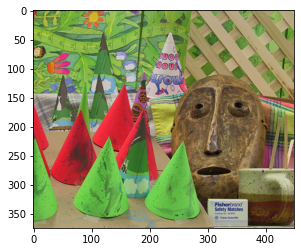

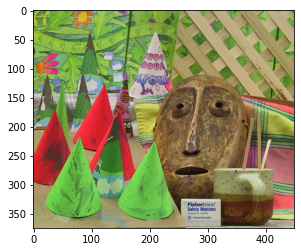

In [3]:
# Load image1
file = 'Cones_im2.jpg'
#file = 'cast-left-1.jpg'
image1 = Image.open(file)
# Convert to grayscale
gray1 = rgb2gray(image1)

# Load image2
file = 'Cones_im6.jpg'
#file = 'cast-right.jpg'
image2 = Image.open(file)
# Convert to grayscale
gray2 = rgb2gray(image2)

plt.imshow(image1)
plt.figure()
plt.imshow(image2)

# Add blurring to reduce noise level

In [4]:
# Smooth image
im1 = gaussFilter(gray1)
im2 = gaussFilter(gray2)

Finding corners...


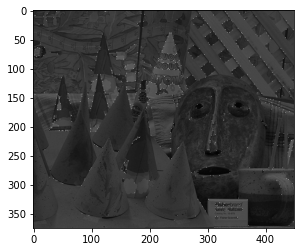

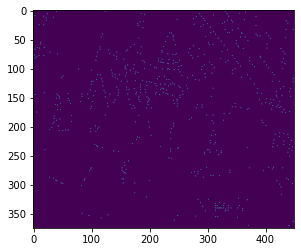

In [5]:
# Find sparse corners
print('Finding corners...')
width = 3
k = 0.05
threshold = 0.01
corners1 = HarrisCorner(im1,threshold,width,k)
corners2 = HarrisCorner(im2,threshold,width,k)

plt.imshow(gray1,cmap='gray')
plt.imshow(corners1>0,cmap='gray',alpha=0.6)

plt.figure()
plt.imshow(corners1>0)

Finding matches...
606 matches found.


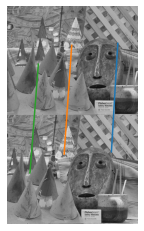

In [6]:
# Find matches
print('Finding matches...')
num_matches = np.sum(corners1>0)
matches = patch2patch(gray1,gray2,corners1,corners2,width,num_matches)
print(matches.shape[0],'matches found.')
drawLines(gray1,gray2,matches,0.9999)
#plt.savefig('matches95.png', dpi=200, bbox_inches='tight', pad_inches=0)

# Constrained Dense Disparity Map Search

In [7]:
def disparityMap(left,right,width,dis_range):
    r,c = np.shape(left)
    denseMap = np.ones([r,c])
    accuracyMap = np.zeros([r,c])

    low = int((width-1)/2)
    high = int((width-1)/2)+1

    for i in range(low,r-high):
        
        for j in range(low,c-high-dis_range[1]):  
            rightPatch = right[i-low:i+high,j-low:j+high]
            best = 0
            
            for k in range(j+dis_range[0],j+dis_range[1]):
                leftPatch = left[i-low:i+high, k-low:k+high]
                new = patch_ncc(leftPatch,rightPatch)

                if new>best:
                    denseMap[i,j] = np.abs(k-j)
                    accuracyMap[i,j] = new

                    #if best>=0.9995:
                    #    break
                    best = new

    return denseMap, accuracyMap


def disparityMapAll(left,right,width):

    left = pad(left,np.ones([width,width]))
    right = pad(right,np.ones([width,width]))

    low = int((width-1)/2)
    high = int((width-1)/2)+1

    r,c = np.shape(left)
    denseMap = np.ones([r-low,c-low])
    accuracyMap = np.zeros([r-low,c-low])

    print(np.shape(left))
    for i in range(low,r-low):
        
        for j in range(low, c-low):  
            rightPatch = right[i-low:i+high,j-low:j+high]
            best = 0
            
            for k in range(low, c-low):
                leftPatch = left[i-low:i+high, k-low:k+high]
                #print(i,j,k)
                new = patch_ncc(leftPatch,rightPatch)

                if new>best:
                    denseMap[i,j] = np.abs(k-j)
                    accuracyMap[i,j] = new
                    best = new

    return denseMap, accuracyMap


dis_range = [10, 55]
dis_range = [0, 450]
width = 7
#maps = disparityMap(gray1,gray2,width,dis_range)
maps2 = disparityMapAll(gray1,gray2,width)

(381, 456)


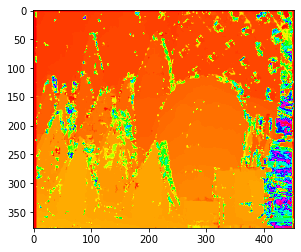

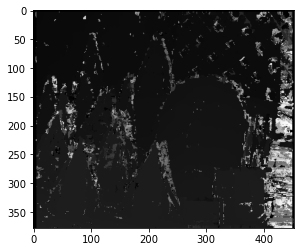

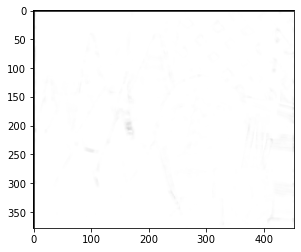

In [9]:
ncc = maps2[1]
#ncc = ncc[width:-width, width:-width-dis_range[1]]

dense = maps2[0]
#dense = dense[width:-width, width:-width-dis_range[1]]

plt.figure()
plt.imshow(dense,cmap='hsv')
plt.savefig('hsv7all.png', dpi=200, bbox_inches='tight', pad_inches=0)

plt.figure()
plt.imshow(dense,cmap='gray', vmin=np.amin(dense), vmax=np.amax(dense))
plt.savefig('gray7all.png', dpi=200, bbox_inches='tight', pad_inches=0)

plt.figure()
plt.imshow(ncc,cmap='gray', vmin=np.amin(ncc), vmax=np.amax(ncc))
plt.savefig('NCCaccuracy7all.png', dpi=200, bbox_inches='tight', pad_inches=0)
